In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .master("local") \
    .appName("AppName") \
    .getOrCreate()
from pyspark.sql.functions import split, col, regexp_extract, expr, count, when, asc, year, quarter, month, weekofyear, hour, day, round, dayofweek

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/14 20:39:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/12/14 20:40:01 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/12/14 20:40:01 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [3]:
from pyspark.ml.feature import StringIndexer
from pyspark.sql import SQLContext, Window
from pyspark.sql.functions import size, split, countDistinct, length, date_format, desc, min, max

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import seaborn as sns

In [5]:
from pyspark.sql.types import StructType, StructField, TimestampType, IntegerType, StringType, FloatType, DoubleType

## original data

In [319]:
%%time
df = spark.read.csv('2020-Mar.csv', header='true', inferSchema='true')
df.show(5)
df.createOrReplaceTempView('original')

+-------------------+----------+----------+-------------------+--------------------+-------+------+---------+--------------------+
|         event_time|event_type|product_id|        category_id|       category_code|  brand| price|  user_id|        user_session|
+-------------------+----------+----------+-------------------+--------------------+-------+------+---------+--------------------+
|2020-03-01 00:00:00|      view|  10900348|2232732105912091273|appliances.kitche...|kitfort|117.63|550295099|23f5ab9e-7774-416...|
|2020-03-01 00:00:01|      view|  14300020|2232732107967300275|   apparel.underwear|  casio|264.37|622070532|edf19213-f0dd-46e...|
|2020-03-01 00:00:03|      view|  13200063|2232732061804790604|furniture.bedroom...|   NULL| 126.1|552832344|608087d8-6b69-21d...|
|2020-03-01 00:00:03|      view| 100077498|2232732085846540487|construction.tool...| tamina|424.72|613391860|5ab6c3d5-edd7-4e1...|
|2020-03-01 00:00:04|      view|   1005014|2232732093077520756|construction.tool...

In [6]:
df.count()

56341241

#### missing value handling

In [14]:
null_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
null_counts.show()

+----------+----------+----------+-----------+-------------+-------+-----+-------+------------+
|event_time|event_type|product_id|category_id|category_code|  brand|price|user_id|user_session|
+----------+----------+----------+-----------+-------------+-------+-----+-------+------------+
|         0|         0|         0|          0|      5938692|8116543|    0|      0|          51|
+----------+----------+----------+-----------+-------------+-------+-----+-------+------------+



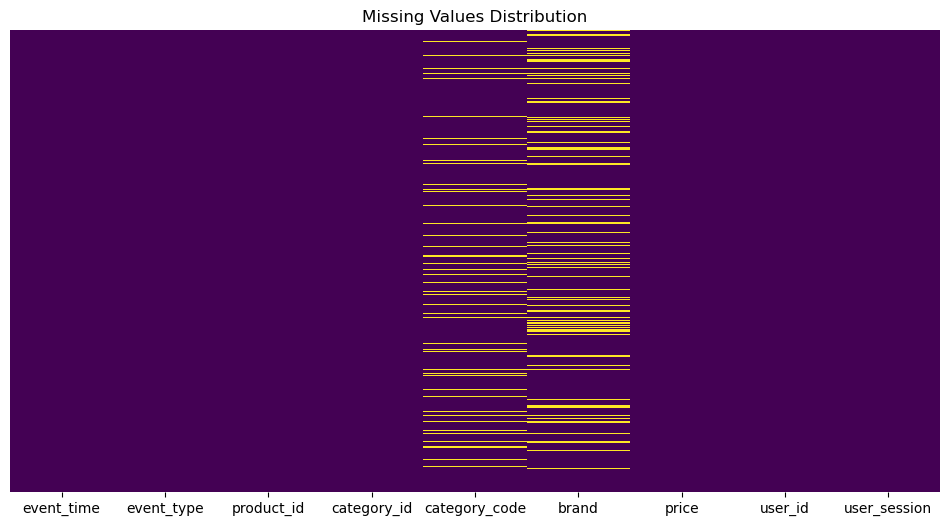

In [12]:
is_null_df = df.select([when(col(c).isNull(), 1).otherwise(0).alias(c) for c in df_Mar.columns])

# sampling10%
sampled_df = is_null_df.sample(False, 0.1)  

# collect to local
local_sampled_df = sampled_df.toPandas()

# heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(local_sampled_df, cbar=False, yticklabels=False, cmap='viridis')
plt.title('Missing Values Distribution')
plt.show()

##### try to fill null value with known info

In [19]:
# count every product_id's brand not null number and total 
brand_info = df.groupBy("product_id") \
              .agg(count("brand").alias("brand_count"), 
                   count("*").alias("total_count"))

# for every product_id, screen brand whitch has both not null and null
inconsistent_brands = brand_info.filter((col("brand_count") > 0) & (col("brand_count") < col("total_count")))

# get first inconsistent product_id（if exist）
first_inconsistent_brand = inconsistent_brands.limit(1).collect()

# show result
if first_inconsistent_brand:
    print("Found inconsistent brand for product_id:", first_inconsistent_brand[0]['product_id'])
else:
    print("No inconsistent brands found")

Found inconsistent brand for product_id: 15201081


In [9]:
# define window
window_spec = Window.partitionBy("product_id").orderBy("event_time")

# caculate the most common brand and category_code
first_brand = first("brand", ignorenulls=True).over(window_spec)
first_category_code = first("category_code", ignorenulls=True).over(window_spec)

# fill null
df = df.withColumn("brand", when(col("brand").isNull(), first_brand).otherwise(col("brand"))) \
              .withColumn("category_code", when(col("category_code").isNull(), first_category_code).otherwise(col("category_code")))


In [18]:
# count every category_id's code not null number and total 
category_info = df.groupBy("category_id") \
              .agg(count("category_code").alias("category_code_count"), 
                   count("*").alias("total_count"))

# for every category_id, screen code whitch has both not null and null
inconsistent_categorys = category_info.filter((col("category_code_count") > 0) & (col("category_code_count") < col("category_code_count")))

# get first inconsistent category_id（if exist）
first_inconsistent_category = inconsistent_categorys.limit(1).collect()

# show result
if first_inconsistent_category:
    print("Found inconsistent category_code for category_id:", first_inconsistent_category[0]['category_id'])
else:
    print("No inconsistent categorys found")

No inconsistent categorys found


In [20]:
final_null_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
final_null_counts.show()

+----------+----------+----------+-----------+-------------+-------+-----+-------+------------+
|event_time|event_type|product_id|category_id|category_code|  brand|price|user_id|user_session|
+----------+----------+----------+-----------+-------------+-------+-----+-------+------------+
|         0|         0|         0|          0|      5938692|8059624|    0|      0|          51|
+----------+----------+----------+-----------+-------------+-------+-----+-------+------------+



#### drop null value & unnecessary cols, covert category_code

In [9]:
%%time
df_na = df.filter(col('category_code').isNull())
df_na.show(5)
df = df.filter(~col('category_code').isNull())
df.show(5)

+-------------------+----------+----------+-------------------+-------------+--------+------+---------+--------------------+
|         event_time|event_type|product_id|        category_id|category_code|   brand| price|  user_id|        user_session|
+-------------------+----------+----------+-------------------+-------------+--------+------+---------+--------------------+
|2020-03-01 00:00:18|      view|  22700202|2232732091643068746|         NULL|   stels|168.34|599238796|34cd3495-3555-431...|
|2020-03-01 00:00:29|      view|  22700755|2232732091643068746|         NULL|    NULL|194.55|540118001|ba7a2925-c415-4d6...|
|2020-03-01 00:00:40|      view|   5400104|2232732082189107324|         NULL|     svc| 32.13|597267713|f2fdcbb1-e644-47c...|
|2020-03-01 00:00:41|      view|  12800075|2232732106792895129|         NULL|kingston|765.76|622090870|b61e2814-061d-45b...|
|2020-03-01 00:00:44|      view|  12701980|2053013553199186187|         NULL|cordiant| 37.32|622089733|19771a05-8f1b-4f6...|


In [12]:
%%time
df_na.count()

CPU times: user 201 ms, sys: 74.4 ms, total: 275 ms
Wall time: 2min 19s


5938692

In [10]:
def split_cat(row):
    split_col = split(row.category_code, "\.", -1)
    return row.withColumn("category_code", split_col.getItem(0))
df = df.transform(split_cat)
df.show(5)

+-------------------+----------+----------+-------------------+-------------+-------+------+---------+--------------------+
|         event_time|event_type|product_id|        category_id|category_code|  brand| price|  user_id|        user_session|
+-------------------+----------+----------+-------------------+-------------+-------+------+---------+--------------------+
|2020-03-01 00:00:00|      view|  10900348|2232732105912091273|   appliances|kitfort|117.63|550295099|23f5ab9e-7774-416...|
|2020-03-01 00:00:01|      view|  14300020|2232732107967300275|      apparel|  casio|264.37|622070532|edf19213-f0dd-46e...|
|2020-03-01 00:00:03|      view|  13200063|2232732061804790604|    furniture|   NULL| 126.1|552832344|608087d8-6b69-21d...|
|2020-03-01 00:00:03|      view| 100077498|2232732085846540487| construction| tamina|424.72|613391860|5ab6c3d5-edd7-4e1...|
|2020-03-01 00:00:04|      view|   1005014|2232732093077520756| construction|samsung|482.73|517021211|0c34308d-c455-40b...|
+-------

In [11]:
df = df.drop(*('category_id', 'brand'))
df.show(5)

+-------------------+----------+----------+-------------+------+---------+--------------------+
|         event_time|event_type|product_id|category_code| price|  user_id|        user_session|
+-------------------+----------+----------+-------------+------+---------+--------------------+
|2020-03-01 00:00:00|      view|  10900348|   appliances|117.63|550295099|23f5ab9e-7774-416...|
|2020-03-01 00:00:01|      view|  14300020|      apparel|264.37|622070532|edf19213-f0dd-46e...|
|2020-03-01 00:00:03|      view|  13200063|    furniture| 126.1|552832344|608087d8-6b69-21d...|
|2020-03-01 00:00:03|      view| 100077498| construction|424.72|613391860|5ab6c3d5-edd7-4e1...|
|2020-03-01 00:00:04|      view|   1005014| construction|482.73|517021211|0c34308d-c455-40b...|
+-------------------+----------+----------+-------------+------+---------+--------------------+
only showing top 5 rows



In [14]:
%%time
incomp_id = df_na.select('user_id').distinct()
incomp_id.coalesce(1).write.csv('incomp_id', header=True)

CPU times: user 260 ms, sys: 69 ms, total: 329 ms
Wall time: 2min 46s


#### category distrib.

In [14]:
%%time
df.createOrReplaceTempView('original')
category = spark.sql("""SELECT category_code, COUNT(*) as count, 
                CONCAT(CAST(ROUND(100 * COUNT(*) / SUM(COUNT(*)) OVER (), 3) AS varchar(10)), '%') AS pct
             FROM original 
             GROUP BY category_code""")
category.show()

23/12/12 23:45:40 WARN CharVarcharUtils: The Spark cast operator does not support char/varchar type and simply treats them as string type. Please use string type directly to avoid confusion. Otherwise, you can set spark.sql.legacy.charVarcharAsString to true, so that Spark treat them as string type as same as Spark 3.0 and earlier
23/12/12 23:45:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/12 23:45:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/12 23:45:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/12 23:49:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/1

+-------------+--------+-------+
|category_code|   count|    pct|
+-------------+--------+-------+
|     medicine|   60563|  0.12%|
|    computers| 2360866| 4.684%|
|         auto|  473730|  0.94%|
|   stationery|   24688| 0.049%|
|        sport| 3122779| 6.196%|
|      apparel| 6794753|13.481%|
|   appliances| 9793526|19.431%|
| country_yard|  172470| 0.342%|
|    furniture| 2829052| 5.613%|
|  accessories|  868024| 1.722%|
|         kids| 1541417| 3.058%|
|  electronics| 6769195| 13.43%|
| construction|15591486|30.934%|
+-------------+--------+-------+

CPU times: user 223 ms, sys: 81.7 ms, total: 305 ms
Wall time: 4min 7s


## sampling

### join with 0.5% stratified sampling

##### drop also all events related to user_ids that have some missing value, just keep the user_ids with full information

In [19]:
incomp_id = spark.read.csv("incomp_id/incomp_id.csv", header=True)

In [20]:
%%time
incomp_id.count()

CPU times: user 5.8 ms, sys: 0 ns, total: 5.8 ms
Wall time: 651 ms


799983

In [26]:
%%time
category = category.select('category_code').rdd.flatMap(lambda x: x).collect()
fractions = {c: 0.005 for c in category}
stratified_sample = df.stat.sampleBy("category_code", fractions, seed=42)
unique_id = stratified_sample.select('user_id').distinct()
unique_id = unique_id.subtract(incomp_id)
unique_id.coalesce(1).write.csv('unique_id', header=True)

CPU times: user 573 ms, sys: 146 ms, total: 719 ms
Wall time: 7min 11s


In [28]:
unique_id = spark.read.csv('unique_id/unique_id.csv', header = True)

In [29]:
unique_id.count()

138930

In [30]:
unique_id.show(5)

+---------+
|  user_id|
+---------+
|568723215|
|564364034|
|580738936|
|615162486|
|606876871|
+---------+
only showing top 5 rows



In [31]:
sampled = unique_id.join(df, on='user_id', how='inner')

In [32]:
%%time
sampled.count()

CPU times: user 331 ms, sys: 35.6 ms, total: 366 ms
Wall time: 2min 55s


6112428

In [33]:
%%time
sampled.coalesce(1).write.csv('sampled', header=True)

CPU times: user 162 ms, sys: 34.7 ms, total: 196 ms
Wall time: 6min 54s


## work on sampled data

#### data overview

In [5]:
schema = StructType([
    StructField("user_id", IntegerType(), True),
    StructField("event_time", TimestampType(), True),
    StructField("event_type", StringType(), True),
    StructField("product_id", IntegerType(), True),
    StructField("category_code", StringType(), True),
    StructField("price", FloatType(), True),
    StructField("user_session", StringType(), True)
])


In [6]:
sampled = spark.read.csv('sampled/sampled.csv', header = True, schema = schema)
sampled.createOrReplaceTempView('sampled')

In [7]:
sampled.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- event_time: timestamp (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_code: string (nullable = true)
 |-- price: float (nullable = true)
 |-- user_session: string (nullable = true)



In [37]:
sampled.count()
sampled.show(5)

6112428

+---------+-------------------+----------+----------+-------------+------+--------------------+
|  user_id|         event_time|event_type|product_id|category_code| price|        user_session|
+---------+-------------------+----------+----------+-------------+------+--------------------+
|513474296|2020-03-01 00:00:21|      view| 100103375|      apparel|185.08|e8135bf7-716a-4a2...|
|553589144|2020-03-01 00:00:23|      view| 100064157|    furniture| 38.59|856bfc47-6210-4fb...|
|621892028|2020-03-01 00:00:23|      view|  26300080|   appliances|416.94|f53c65ec-431f-4ff...|
|522892734|2020-03-01 00:00:44|      view|   3300441|    computers| 48.88|e365e034-95b9-49b...|
|553589144|2020-03-01 00:00:45|      view|   3801237|    furniture| 30.86|856bfc47-6210-4fb...|
+---------+-------------------+----------+----------+-------------+------+--------------------+
only showing top 5 rows



In [42]:
%%time
to_print = ''
for c in sampled.columns:
    null_count = sampled.filter(col(c).isNull()).count()
    to_print += f"Column {c} has {null_count} null values.\n"
    #print(f"Column {c} has {null_count} null values.")
print(to_print[:-1])

Column user_id has 0 null values.
Column event_time has 0 null values.
Column event_type has 0 null values.
Column product_id has 0 null values.
Column category_code has 0 null values.
Column price has 0 null values.
Column user_session has 0 null values.
CPU times: user 192 ms, sys: 38.9 ms, total: 231 ms
Wall time: 1min 40s


In [7]:
%%time
to_print = ''
for c in sampled.columns:
    count = sampled.select(col(c)).distinct().count()
    to_print += f"Column {c} has {count} unique values.\n"
print(to_print[:-1])

Column user_id has 138930 unique values.
Column event_time has 2093648 unique values.
Column event_type has 3 unique values.
Column product_id has 128312 unique values.
Column category_code has 13 unique values.
Column price has 46066 unique values.
Column user_session has 1025154 unique values.
CPU times: user 158 ms, sys: 33.4 ms, total: 191 ms
Wall time: 2min 40s


#### product with zero price

In [38]:
sampled.describe(['price']).show()

+-------+------------------+
|summary|             price|
+-------+------------------+
|  count|           6112428|
|   mean| 336.9728050787383|
| stddev|368.16628269781785|
|    min|               0.0|
|    max|           2574.07|
+-------+------------------+



In [39]:
price_0 = sampled.filter(sampled.price == '0.00')

In [40]:
price_0.count()

4630

In [69]:
price_0.groupby('category_code').count().show() # outliers?

+-------------+-----+
|category_code|count|
+-------------+-----+
|     medicine|   66|
|    computers|  455|
|         auto|   24|
|        sport|  168|
|      apparel|  764|
|   appliances|  861|
| country_yard|   16|
|    furniture|  438|
|  accessories|   29|
|         kids|  260|
|  electronics|  957|
| construction|  592|
+-------------+-----+



In [71]:
price_0.show(5, truncate = False)

+---------+-------------------+----------+----------+-------------+-----+------------------------------------+
|user_id  |event_time         |event_type|product_id|category_code|price|user_session                        |
+---------+-------------------+----------+----------+-------------+-----+------------------------------------+
|602512858|2020-03-01 03:37:16|view      |100054912 |electronics  |0.0  |0caba12f-174a-c17e-b8a9-ca457d76eab0|
|602512858|2020-03-01 03:37:46|view      |100054945 |electronics  |0.0  |0caba12f-174a-c17e-b8a9-ca457d76eab0|
|512440959|2020-03-01 03:55:36|view      |100068651 |appliances   |0.0  |ce6072ad-f3de-4d33-a9d6-d1de6cb29d8d|
|516371217|2020-03-01 04:04:57|view      |11500857  |computers    |0.0  |40812bcf-dc4b-48a1-b9cd-5ea660238b09|
|519545377|2020-03-01 04:54:18|view      |100106071 |computers    |0.0  |78ad7f43-abe7-45be-9096-1c9ea794142c|
+---------+-------------------+----------+----------+-------------+-----+------------------------------------+
o

In [76]:
price_0.filter(price_0.event_type == 'purchase').show()

+-------+----------+----------+----------+-------------+-----+------------+
|user_id|event_time|event_type|product_id|category_code|price|user_session|
+-------+----------+----------+----------+-------------+-----+------------+
+-------+----------+----------+----------+-------------+-----+------------+



In [8]:
avg_price_0 = spark.sql('''SELECT product_id, AVG(price)
                             FROM sampled
                             WHERE product_id IN ( SELECT product_id
                                                   FROM sampled s
                                                   WHERE price = 0.0)
                             GROUP BY product_id''')
avg_price_0.show(5)

+----------+------------------+
|product_id|        avg(price)|
+----------+------------------+
| 100146207|127.23500061035156|
| 100145591|1780.2819885253907|
| 100133625|               0.0|
| 100147226| 79.27999877929688|
| 100149301| 77.03249931335449|
+----------+------------------+
only showing top 5 rows



In [9]:
sampled.filter(sampled.product_id == 100145591).show(3)

+---------+-------------------+----------+----------+-------------+-------+--------------------+
|  user_id|         event_time|event_type|product_id|category_code|  price|        user_session|
+---------+-------------------+----------+----------+-------------+-------+--------------------+
|515736678|2020-03-03 09:02:53|      view| 100145591|      apparel|    0.0|d6914f80-80ee-4ef...|
|616186254|2020-03-03 14:15:01|      view| 100145591|      apparel|1776.88|642351f1-6738-44e...|
|616186254|2020-03-03 15:27:38|      view| 100145591|      apparel|1776.88|d9ec5371-0e65-414...|
+---------+-------------------+----------+----------+-------------+-------+--------------------+
only showing top 3 rows



#### event type analysis

In [43]:
spark.sql("""SELECT event_type, COUNT(*) as count, 
                CONCAT(CAST(ROUND(100 * COUNT(*) / SUM(COUNT(*)) OVER (), 3) AS varchar(10)), '%') AS pct
             FROM original 
             GROUP BY event_type""").show()
spark.sql("""SELECT event_type, COUNT(*) as count, 
                CONCAT(CAST(ROUND(100 * COUNT(*) / SUM(COUNT(*)) OVER (), 3) AS varchar(10)), '%') AS pct
             FROM sampled 
             GROUP BY event_type""").show()

23/12/04 17:49:35 WARN CharVarcharUtils: The Spark cast operator does not support char/varchar type and simply treats them as string type. Please use string type directly to avoid confusion. Otherwise, you can set spark.sql.legacy.charVarcharAsString to true, so that Spark treat them as string type as same as Spark 3.0 and earlier
23/12/04 17:49:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/04 17:49:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/04 17:49:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/04 17:52:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/0

+----------+--------+------+
|event_type|   count|   pct|
+----------+--------+------+
|  purchase|  941869|1.869%|
|      view|46808637|92.87%|
|      cart| 2652043|5.262%|
+----------+--------+------+



23/12/04 17:52:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/04 17:52:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/04 17:52:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+----------+-------+-------+
|event_type|  count|    pct|
+----------+-------+-------+
|  purchase| 138883| 2.272%|
|      view|5598685|91.595%|
|      cart| 374860| 6.133%|
+----------+-------+-------+



23/12/04 17:52:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/04 17:52:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/04 17:52:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/04 17:52:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


## split the sampled data into 2 pools

In [99]:
prod_session = spark.sql('''SELECT DISTINCT user_session, product_id
                            FROM sampled
                            WHERE event_type = "purchase"''')
prod_session.count()
prod_session.show(5)

124275

+--------------------+----------+
|        user_session|product_id|
+--------------------+----------+
|a1614c0c-e55e-4f7...|   4803879|
|3ec35774-7870-4d3...|   1004258|
|a7faf2c8-3459-45f...|   1801983|
|5775c1b3-d4de-482...|   1004785|
|58df7dab-573d-4e9...|   1005212|
+--------------------+----------+
only showing top 5 rows



In [100]:
keys = ['user_session', 'product_id']
purchased = prod_session.join(sampled, on = keys, how = 'inner')

In [102]:
unique_prod_session = sampled.select(keys).distinct()
noPurchase_prod_session = unique_prod_session.subtract(prod_session)

In [103]:
noPurchase = noPurchase_prod_session.join(sampled, on = keys, how = 'inner')

In [105]:
purchased.coalesce(1).write.csv('purchased', header=True)
noPurchase.coalesce(1).write.csv('noPurchase', header=True)

23/12/05 16:57:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/05 16:57:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/05 16:57:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/05 16:57:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/05 16:57:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/05 16:57:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


### Split datasets overview

In [30]:
schema = StructType([
    StructField("user_session", StringType(), True),
    StructField("product_id", IntegerType(), True),
    StructField("user_id", IntegerType(), True),
    StructField("event_time", TimestampType(), True),
    StructField("event_type", StringType(), True),
    StructField("category_code", StringType(), True),
    StructField("price", FloatType(), True)
])

In [31]:
purchased = spark.read.csv('purchased_new/purchased.csv', header = True, schema = schema)
noPurchase = spark.read.csv('noPurchase_new/noPurchase.csv', header = True, schema = schema)
purchased.show(5)
noPurchase.show(5)

+--------------------+----------+---------+-------------------+----------+-------------+-----+
|        user_session|product_id|  user_id|         event_time|event_type|category_code|price|
+--------------------+----------+---------+-------------------+----------+-------------+-----+
|00024c6d-5a3c-4f6...| 100040247|518159380|2020-03-03 06:27:00|      view|      apparel|66.67|
|00024c6d-5a3c-4f6...| 100040247|518159380|2020-03-03 06:27:22|      view|      apparel|66.67|
|00024c6d-5a3c-4f6...| 100040247|518159380|2020-03-03 06:28:19|      view|      apparel|66.67|
|00024c6d-5a3c-4f6...| 100040247|518159380|2020-03-03 06:28:29|      cart|      apparel|66.67|
|00024c6d-5a3c-4f6...| 100040247|518159380|2020-03-03 06:29:45|  purchase|      apparel|66.67|
+--------------------+----------+---------+-------------------+----------+-------------+-----+
only showing top 5 rows

+--------------------+----------+---------+-------------------+----------+-------------+------+
|        user_session|pr

In [51]:
purchased.count()
noPurchase.count()

679580

5432848

In [32]:
purchased.createOrReplaceTempView("purchased")
noPurchase.createOrReplaceTempView("noPurchase")

In [15]:
print('proportion of each event type in purchased dataset')
spark.sql("""SELECT event_type, COUNT(*) as count, 
                CONCAT(CAST(ROUND(100 * COUNT(*) / SUM(COUNT(*)) OVER (), 3) AS varchar(10)), '%') AS pct
             FROM purchased 
             GROUP BY event_type""").show()
print('proportion of each event type in noPurchase dataset')
spark.sql("""SELECT event_type, COUNT(*) as count, 
                CONCAT(CAST(ROUND(100 * COUNT(*) / SUM(COUNT(*)) OVER (), 3) AS varchar(10)), '%') AS pct
             FROM noPurchase 
             GROUP BY event_type""").show()

proportion of each event type in purchased dataset


23/12/10 16:44:29 WARN CharVarcharUtils: The Spark cast operator does not support char/varchar type and simply treats them as string type. Please use string type directly to avoid confusion. Otherwise, you can set spark.sql.legacy.charVarcharAsString to true, so that Spark treat them as string type as same as Spark 3.0 and earlier
23/12/10 16:44:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/10 16:44:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/10 16:44:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/10 16:44:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/1

+----------+------+-------+
|event_type| count|    pct|
+----------+------+-------+
|  purchase|138883|20.437%|
|      view|330236|48.594%|
|      cart|210461|30.969%|
+----------+------+-------+

proportion of each event type in noPurchase dataset


23/12/10 16:44:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/10 16:44:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/10 16:44:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/10 16:44:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+----------+-------+-------+
|event_type|  count|    pct|
+----------+-------+-------+
|      view|5268449|96.974%|
|      cart| 164399| 3.026%|
+----------+-------+-------+



## data understanding

### time distribution of visiting the site

* the days included in the weeks of the year

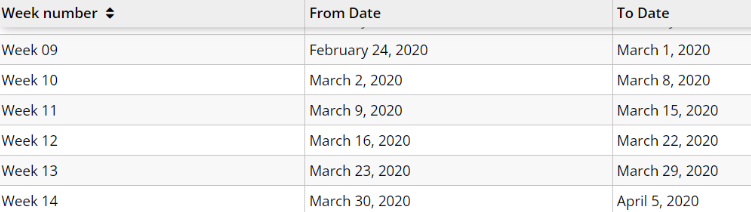

<Figure size 1000x600 with 0 Axes>

<BarContainer object of 24 artists>

Text(0.5, 1.0, 'Distribution of Shopping hours')

Text(0.5, 0, 'the hour')

Text(0, 0.5, 'Count')

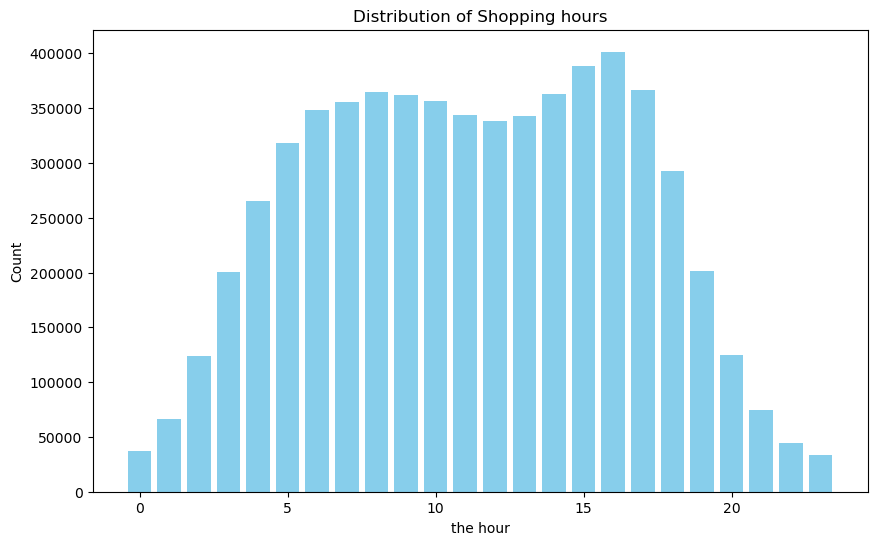

<Figure size 1000x600 with 0 Axes>

<BarContainer object of 31 artists>

Text(0.5, 1.0, 'Distribution of Shopping days')

Text(0.5, 0, 'the day')

Text(0, 0.5, 'Count')

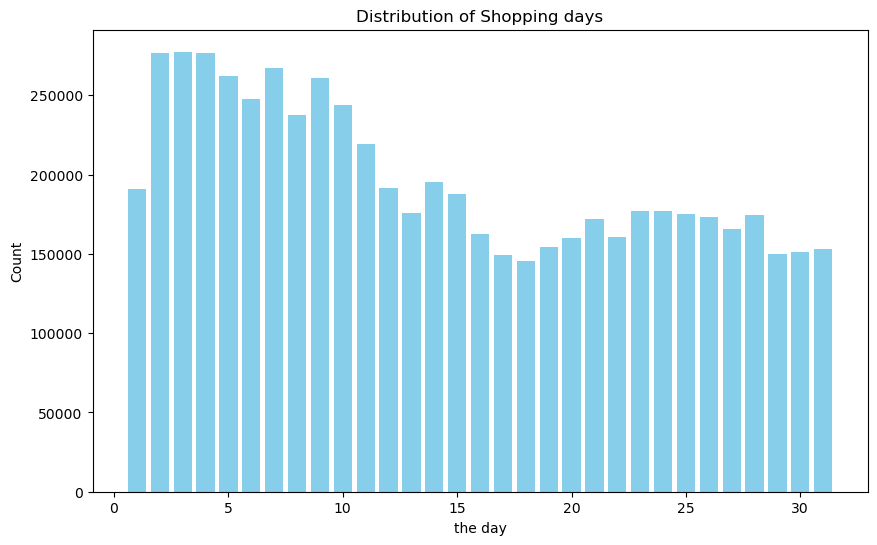

<Figure size 1000x600 with 0 Axes>

<BarContainer object of 6 artists>

Text(0.5, 1.0, 'Distribution of Shopping weeks')

Text(0.5, 0, 'the week')

Text(0, 0.5, 'Count')

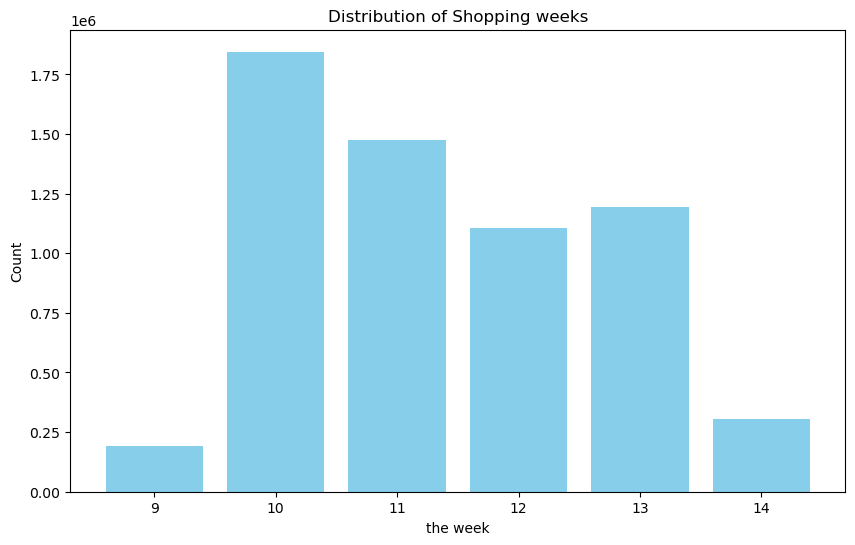

In [10]:
sampled = sampled.withColumns({"hour": hour("event_time"), 'day': day('event_time'),  "week": weekofyear("event_time")})
measures = ['hour', 'day', 'week']
for measure in measures:
    rdd = sampled.select(measure).rdd.flatMap(lambda x: x)

# Count the occurrences of each hour
    counts = rdd.countByValue()

# Extract hours and counts from the dictionary
    x, y = zip(*sorted(counts.items()))

    plt.figure(figsize=(10, 6))
    plt.bar(x, y, color='skyblue')
    plt.title(f"Distribution of Shopping {measure}s")
    plt.xlabel(f"the {measure}")
    plt.ylabel("Count")
    plt.show()

In [15]:
print('''
filtering the last 5 rows to see if April included but it wasn't
Ps same for week 9 date is 100% March only ..
''')

sampled = sampled.withColumn("day_of_week", dayofweek("event_time")).withColumn("week_of_year", weekofyear("event_time"))
specific_week = sampled.filter(col("week_of_year") == 14)
ordered_week = specific_week.orderBy(col("event_time").desc())
last_5_rows = ordered_week.limit(5) # Tail
last_5_rows.show()


filtering the last 5 rows to see if April included but it wasn't
Ps same for week 9 date is 100% March only ..



+---------+-------------------+----------+----------+-------------+------+--------------------+----+---+----+-----------+------------+
|  user_id|         event_time|event_type|product_id|category_code| price|        user_session|hour|day|week|day_of_week|week_of_year|
+---------+-------------------+----------+----------+-------------+------+--------------------+----+---+----+-----------+------------+
|572260610|2020-03-31 23:59:55|      view|   1701027|   appliances|154.42|2e16ffb5-996f-40d...|  23| 31|  14|          3|          14|
|603697911|2020-03-31 23:59:53|      view| 100120527|  electronics|411.83|75d35365-cb0e-4a5...|  23| 31|  14|          3|          14|
|572260610|2020-03-31 23:59:50|      cart|   1701027|   appliances|154.42|2e16ffb5-996f-40d...|  23| 31|  14|          3|          14|
|550985043|2020-03-31 23:59:50|      view|   1801503|   appliances|203.09|8a9edb0e-9d66-bb0...|  23| 31|  14|          3|          14|
|572260610|2020-03-31 23:59:48|      view|   1701027|  

<Figure size 1000x600 with 0 Axes>

<BarContainer object of 31 artists>

Text(0.5, 1.0, 'Distribution of Days in the Month (Combined Across Weeks)')

Text(0.5, 0, 'Day of the Week')

Text(0, 0.5, 'Count')

([<matplotlib.axis.XTick at 0x7f6be3d58af0>,
 [Text(1, 0, 'Mon'),
  Text(2, 0, 'Tue'),
  Text(3, 0, 'Wed'),
  Text(4, 0, 'Thu'),
  Text(5, 0, 'Fri'),
  Text(6, 0, 'Sat'),
  Text(7, 0, 'Sun')])

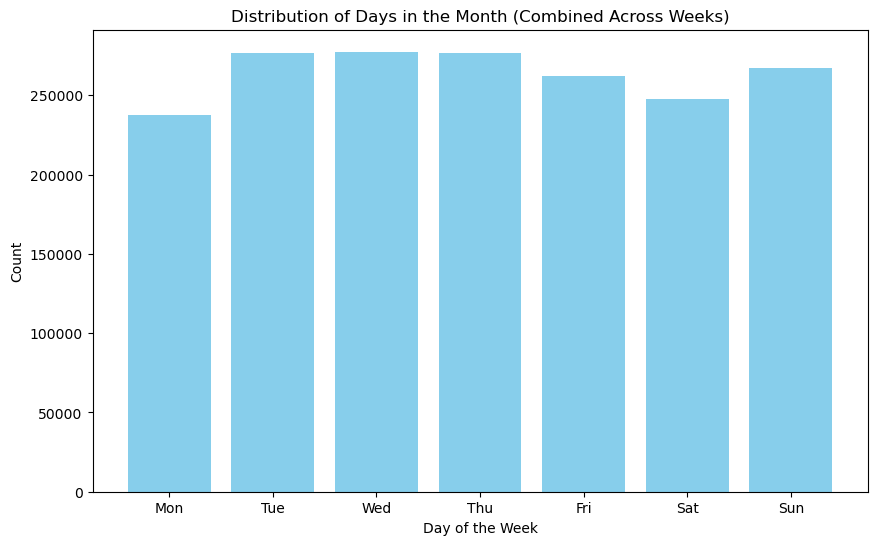

In [279]:
# Distribution of Days in the Month

day_week_rdd = sampled.select("day_of_week", "week_of_year").rdd.flatMap(lambda x: [(x[0], x[1])])

# Count the occurrences of each day of the week and week of the year combination
day_week_counts = day_week_rdd.countByValue()

days_weeks, counts = zip(*sorted(day_week_counts.items()))
days, weeks = zip(*days_weeks)


plt.figure(figsize=(10, 6))
plt.bar(days, counts, color='skyblue')
plt.title("Distribution of Days in the Month (Combined Across Weeks)")
plt.xlabel("Day of the Week")
plt.ylabel("Count")
plt.xticks(range(1, 8), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

### category distribution

In [14]:
category = sampled.groupby('category_code').count()
category.show()

+-------------+-------+
|category_code|  count|
+-------------+-------+
|     medicine|   2860|
|    computers| 272772|
|         auto|  57653|
|   stationery|   1117|
|        sport| 341152|
|      apparel| 634292|
|   appliances|1202082|
| country_yard|  15575|
|    furniture| 263711|
|  accessories|  53324|
|         kids| 156294|
|  electronics| 947312|
| construction|2164284|
+-------------+-------+



CPU times: user 90.8 ms, sys: 2.68 ms, total: 93.4 ms
Wall time: 14.2 s


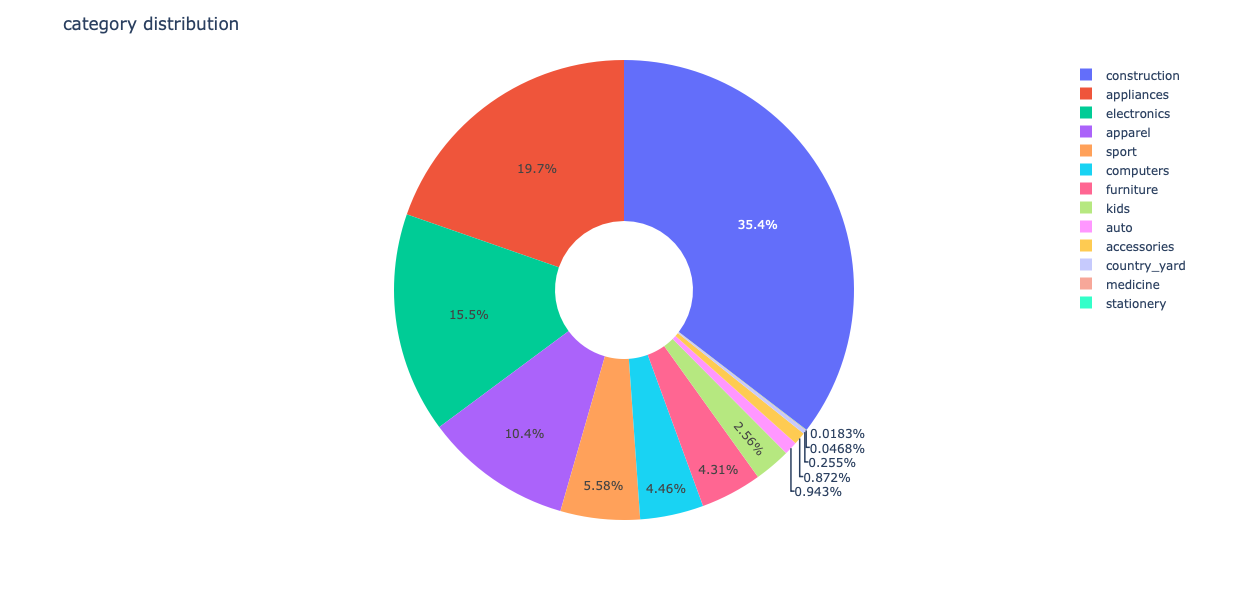

In [15]:
%%time
category = category.toPandas()
pie_char = px.pie(names=category['category_code'], values=category['count'], hole=0.3)
pie_char.update_layout({"title":{"text":"category distribution"}}, width=800, height=600 )

#### for purchased data

#### category distribution for purchased

23/12/07 15:27:22 WARN CharVarcharUtils: The Spark cast operator does not support char/varchar type and simply treats them as string type. Please use string type directly to avoid confusion. Otherwise, you can set spark.sql.legacy.charVarcharAsString to true, so that Spark treat them as string type as same as Spark 3.0 and earlier
23/12/07 15:27:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/07 15:27:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/07 15:27:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/07 15:27:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/12/0

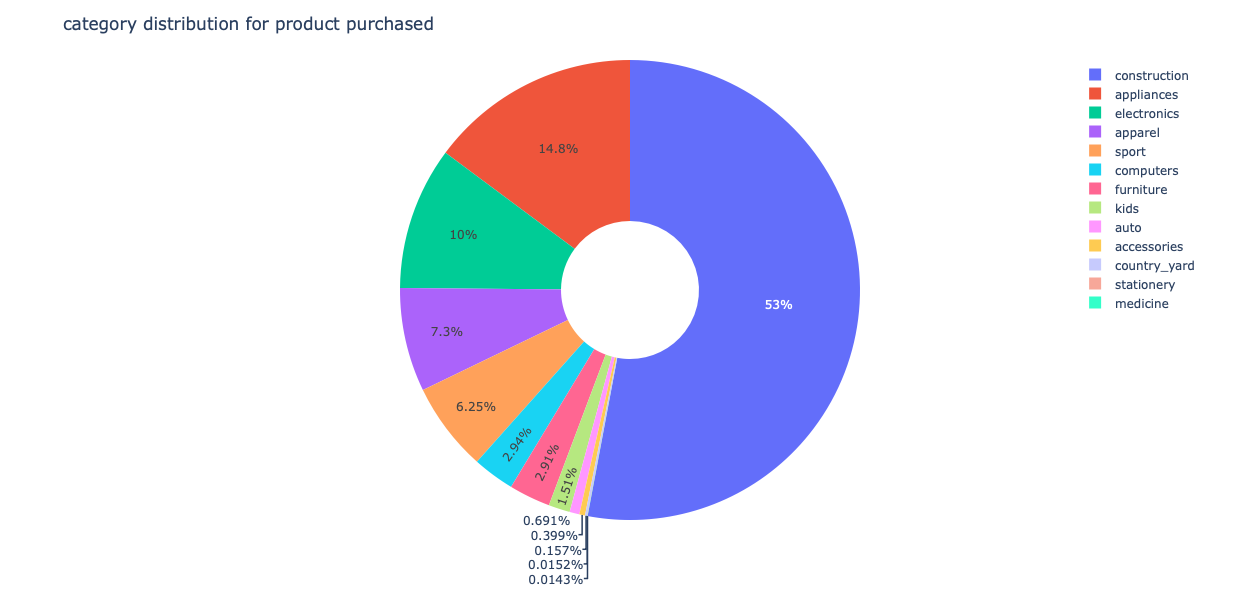

In [341]:
category_pur = purchased.groupby('category_code').count()
category_pur = category_pur.toPandas()
pie_char = px.pie(names=category_pur['category_code'], values=category_pur['count'], hole=0.3)
pie_char.update_layout({"title":{"text":"category distribution for product purchased"}}, width=800, height=600 )

##### purchased the same product multiple times

In [49]:
count = spark.sql("""SELECT user_session, category_code, price,
                        COUNT(CASE WHEN event_type = 'purchase' THEN 1 END) AS num_purchases, 
                        COUNT(DISTINCT product_id) AS count_product
                     FROM purchased
                     GROUP BY user_session, category_code, price""")
count.show(5)
repeated_purchases = count.filter(col('num_purchases') > col('count_product'))
repeated_purchases.show(5)

+--------------------+-------------+-------+-------------+-------------+
|        user_session|category_code|  price|num_purchases|count_product|
+--------------------+-------------+-------+-------------+-------------+
|78a304ef-21ea-489...|        sport| 169.48|            2|            1|
|e1f034f2-a5bd-4b8...| construction|  178.9|            1|            1|
|ef9177e0-78d5-466...|   appliances| 109.37|            1|            1|
|b151c196-0b21-412...| construction|1368.09|            1|            1|
|f944d491-d916-4a0...| construction| 411.31|            1|            1|
+--------------------+-------------+-------+-------------+-------------+
only showing top 5 rows



+--------------------+-------------+------+-------------+-------------+
|        user_session|category_code| price|num_purchases|count_product|
+--------------------+-------------+------+-------------+-------------+
|78a304ef-21ea-489...|        sport|169.48|            2|            1|
|fb0d1e42-04ce-416...| construction|223.92|            2|            1|
|bb223ab5-3a15-40c...|  electronics|360.34|            3|            1|
|715930bc-2eed-42e...|         auto|237.07|            2|            1|
|073cc2b8-4ce3-4f4...| construction|127.16|            2|            1|
+--------------------+-------------+------+-------------+-------------+
only showing top 5 rows



In [50]:
repeated_pur_pd = repeated_purchases.toPandas()

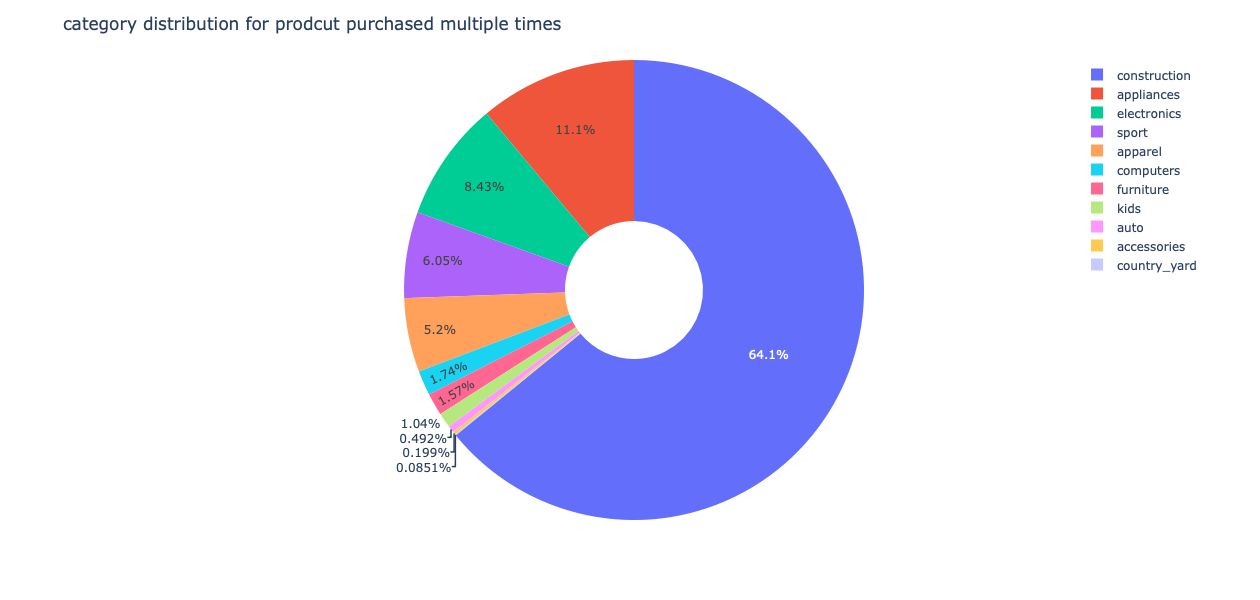

In [52]:
pie_char = px.pie(names=repeated_pur_pd['category_code'], hole=0.3)
pie_char.update_layout({"title":{"text":"category distribution for prodcut purchased multiple times"}}, width=800, height=600 )

### time spent for one purchase

In [21]:
schema_pur = StructType([
    StructField("user_session", StringType(), True),
    StructField("product_id", IntegerType(), True),
    StructField("user_id", IntegerType(), True),
    StructField("category_code", StringType(), True),
    StructField("price", FloatType(), True),
    StructField("AddedToCart", IntegerType(), True),
    StructField("eventDay", IntegerType(), True),
    StructField("count_view", IntegerType(), True),
    StructField("timeSpent_sec", IntegerType(), True),
    StructField("isPurchased", IntegerType(), True),
])

pur = spark.read.csv('purchased_new.csv', header = True, schema = schema_pur)
pur.show(3)

+--------------------+----------+---------+-------------+-----+-----------+--------+----------+-------------+-----------+
|        user_session|product_id|  user_id|category_code|price|AddedToCart|eventDay|count_view|timeSpent_sec|isPurchased|
+--------------------+----------+---------+-------------+-----+-----------+--------+----------+-------------+-----------+
|00002b33-422d-4a0...|  19100023|517463118| construction|65.48|          1|       9|         2|          589|          1|
|00007ae6-150b-41f...|   3601365|616389042|   appliances|95.21|          1|      15|         3|          355|          1|
|00024c6d-5a3c-4f6...| 100040247|518159380|      apparel|66.67|          1|       3|         3|          165|          1|
+--------------------+----------+---------+-------------+-----+-----------+--------+----------+-------------+-----------+
only showing top 3 rows



In [22]:
timeSpent = pur.select(['user_session', 'user_id','category_code','price','timeSpent_sec'])
timeSpent_pd = timeSpent.toPandas()
timeSpent_pd.head()

,user_session,user_id,category_code,price,timeSpent_sec
0,00002b33-422d-4a07-a3c1-0193afd045d3,517463118,construction,65.480003,589
1,00007ae6-150b-41f4-806b-ab27bf8ac7af,616389042,appliances,95.209999,355
2,00024c6d-5a3c-4f64-80ad-be2ba55d2c5e,518159380,apparel,66.669998,165
3,000298bc-b454-45fc-80bc-9907ba580ccb,573501390,electronics,442.739990,42
4,0002f825-fdad-4b77-9021-79a215e97de1,599277587,construction,170.660004,3299


In [23]:
timeSpent_pd['timeSpent_sec'].describe()

count    122537.000000
mean        315.493565
std        3293.474127
min           7.000000
25%          44.000000
50%          95.000000
75%         227.000000
max      684915.000000
Name: timeSpent_sec, dtype: float64

In [24]:
bins_log = np.logspace(0, np.log10(timeSpent_pd['timeSpent_sec'].max()), 20)
bins_log

array([1.00000000e+00, 2.02833074e+00, 4.11412559e+00, 8.34480740e+00,
       1.69260294e+01, 3.43315857e+01, 6.96358105e+01, 1.41244455e+02,
       2.86490470e+02, 5.81097427e+02, 1.17865777e+03, 2.39070779e+03,
       4.84914611e+03, 9.83567212e+03, 1.99499961e+04, 4.04651903e+04,
       8.20767895e+04, 1.66478875e+05, 3.37674220e+05, 6.84915000e+05])

<Figure size 1000x600 with 0 Axes>

<Axes: ylabel='Frequency'>

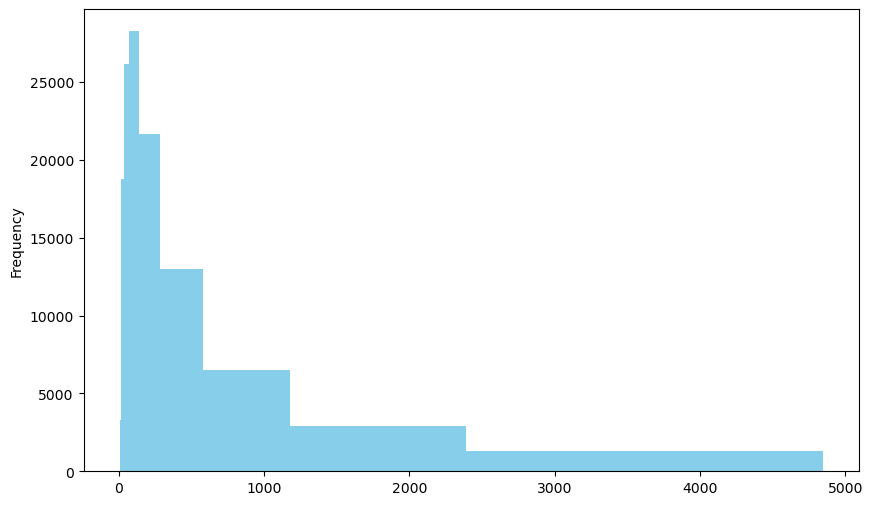

<Figure size 1000x600 with 0 Axes>

<Axes: ylabel='Frequency'>

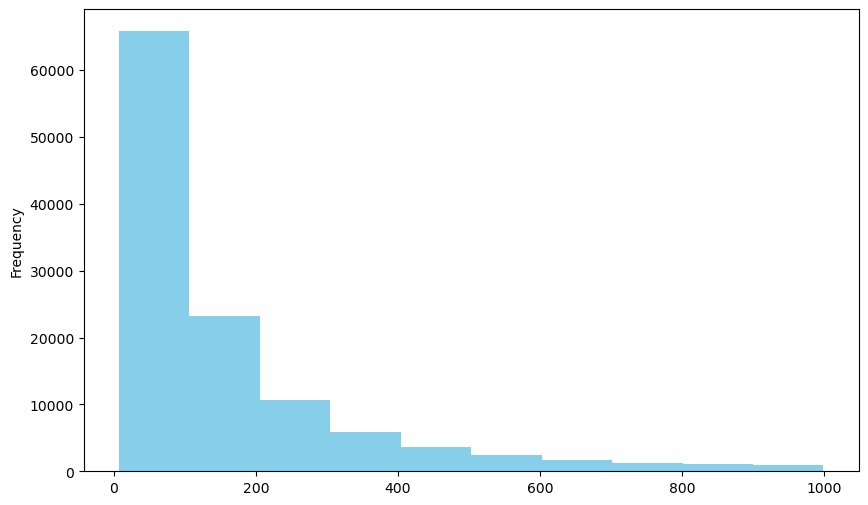

In [25]:
plt.figure(figsize=(10, 6))
timeSpent_pd['timeSpent_sec'].plot.hist(bins = bins_log[bins_log < 5000], color='skyblue')
plt.show()

plt.figure(figsize=(10, 6))
timeSpent_pd[timeSpent_pd['timeSpent_sec'] < 1000]['timeSpent_sec'].plot.hist(color='skyblue')
plt.show()

In [26]:
timeSpent_category = timeSpent_pd.groupby('category_code')['timeSpent_sec'].mean()
timeSpent_userId = timeSpent_pd.groupby('user_id')['timeSpent_sec'].mean()

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='category_code'>

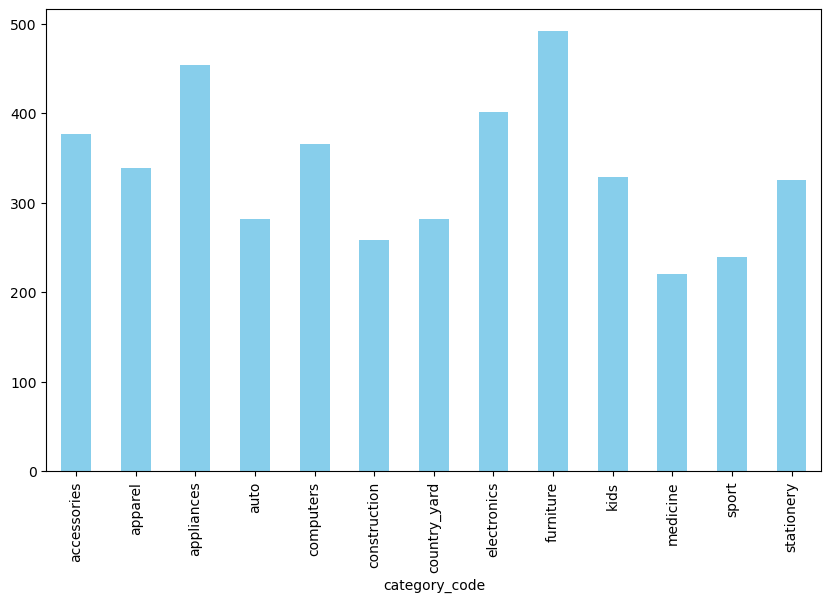

In [27]:
plt.figure(figsize=(10, 6))
timeSpent_category.plot.bar(color='skyblue')